# Project 2: Analysis of Recent College Graduates Dataset

This notebook analyzes the 'recent-grads.csv' dataset which contains information about college majors and their employment outcomes for recent graduates.

In [14]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA

# Set plot style
plt.style.use('seaborn-v0_8')  # Updated to use the correct style name
sns.set_palette('colorblind')
sns.set_context('notebook')

## 1. Data Summary and Variable Description

The dataset contains information about recent college graduates, their majors, employment statistics, gender composition, and earnings. For this analysis, we will focus on the following variables:

1. **Median**: The median salary of recent graduates in each major (in USD)
2. **Unemployment_rate**: The fraction of recent graduates who are unemployed
3. **ShareWomen**: The proportion of graduates in the major who are female
4. **Major_category**: The category of the major (e.g., Engineering, Business, etc.)

With these variables, we'll explore relationships between salary, gender composition, unemployment, and major categories.

In [15]:
# Load the dataset
df = pd.read_csv('recent-grads.csv')

# Display the first few rows
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (173, 21)


,Rank,Major_code,Major,Total,Men,Women,Major_category,ShareWomen,Sample_size,Employed,...,Part_time,Full_time_year_round,Unemployed,Unemployment_rate,Median,P25th,P75th,College_jobs,Non_college_jobs,Low_wage_jobs
0,1,2419,PETROLEUM ENGINEERING,2339.0,2057.0,282.0,Engineering,0.120564,36,1976,...,270,1207,37,0.018381,110000,95000,125000,1534,364,193
1,2,2416,MINING AND MINERAL ENGINEERING,756.0,679.0,77.0,Engineering,0.101852,7,640,...,170,388,85,0.117241,75000,55000,90000,350,257,50
2,3,2415,METALLURGICAL ENGINEERING,856.0,725.0,131.0,Engineering,0.153037,3,648,...,133,340,16,0.024096,73000,50000,105000,456,176,0
3,4,2417,NAVAL ARCHITECTURE AND MARINE ENGINEERING,1258.0,1123.0,135.0,Engineering,0.107313,16,758,...,150,692,40,0.050125,70000,43000,80000,529,102,0
4,5,2405,CHEMICAL ENGINEERING,32260.0,21239.0,11021.0,Engineering,0.341631,289,25694,...,5180,16697,1672,0.061098,65000,50000,75000,18314,4440,972


In [16]:
# Check for missing values
print("Missing values in each column:")
df.isnull().sum()

Missing values in each column:


Rank                    0
Major_code              0
Major                   0
Total                   1
Men                     1
Women                   1
Major_category          0
ShareWomen              1
Sample_size             0
Employed                0
Full_time               0
Part_time               0
Full_time_year_round    0
Unemployed              0
Unemployment_rate       0
Median                  0
P25th                   0
P75th                   0
College_jobs            0
Non_college_jobs        0
Low_wage_jobs           0
dtype: int64

In [17]:
# Let's handle missing values
df_clean = df.dropna(subset=['Median', 'Unemployment_rate', 'ShareWomen'])
print(f"Clean dataset shape: {df_clean.shape}")

Clean dataset shape: (172, 21)


## 2. Summary Statistics for Selected Variables

Let's calculate and display summary statistics for our variables of interest.

In [18]:
# Summary statistics for numeric variables
print("Summary statistics for key numeric variables:")
df_clean[['Median', 'Unemployment_rate', 'ShareWomen']].describe()

Summary statistics for key numeric variables:


,Median,Unemployment_rate,ShareWomen
count,172.000000,172.000000,172.000000
mean,40076.744186,0.068024,0.522223
std,11461.388773,0.030340,0.231205
min,22000.000000,0.000000,0.000000
25%,33000.000000,0.050261,0.336026
50%,36000.000000,0.067544,0.534024
75%,45000.000000,0.087247,0.703299
max,110000.000000,0.177226,0.968954


In [19]:
# Count of majors in each major category
print("Distribution of majors by category:")
major_category_counts = df_clean['Major_category'].value_counts()
major_category_counts


Distribution of majors by category:


Major_category
Engineering                            29
Education                              16
Humanities & Liberal Arts              15
Biology & Life Science                 14
Business                               13
Health                                 12
Computers & Mathematics                11
Physical Sciences                      10
Agriculture & Natural Resources         9
Psychology & Social Work                9
Social Science                          9
Arts                                    8
Industrial Arts & Consumer Services     7
Law & Public Policy                     5
Communications & Journalism             4
Interdisciplinary                       1
Name: count, dtype: int64

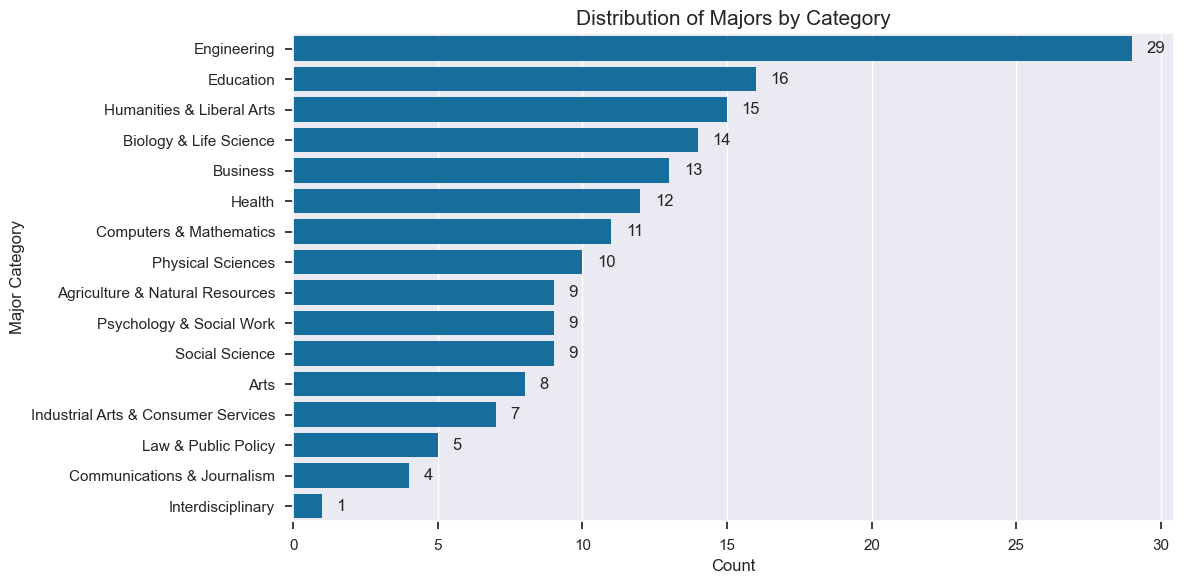

In [40]:

# Visualize the distribution of major categories using a bar chart
plt.figure(figsize=(12, 6))
ax = sns.countplot(y='Major_category', data=df_clean, order=major_category_counts.index)
plt.title('Distribution of Majors by Category', fontsize=15)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Major Category', fontsize=12)

# Add count labels to the bars
for i, count in enumerate(major_category_counts):
    ax.text(count + 0.5, i, str(count), va='center')

plt.tight_layout()
plt.show()


## 3. Cluster Analysis

Now, let's perform a cluster analysis on our dataset using K-means clustering to identify patterns among majors.

In [21]:
# Select variables for clustering
cluster_vars = ['Median', 'Unemployment_rate', 'ShareWomen']
X = df_clean[cluster_vars].copy()

# Standardize the variables (important for clustering)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=cluster_vars)

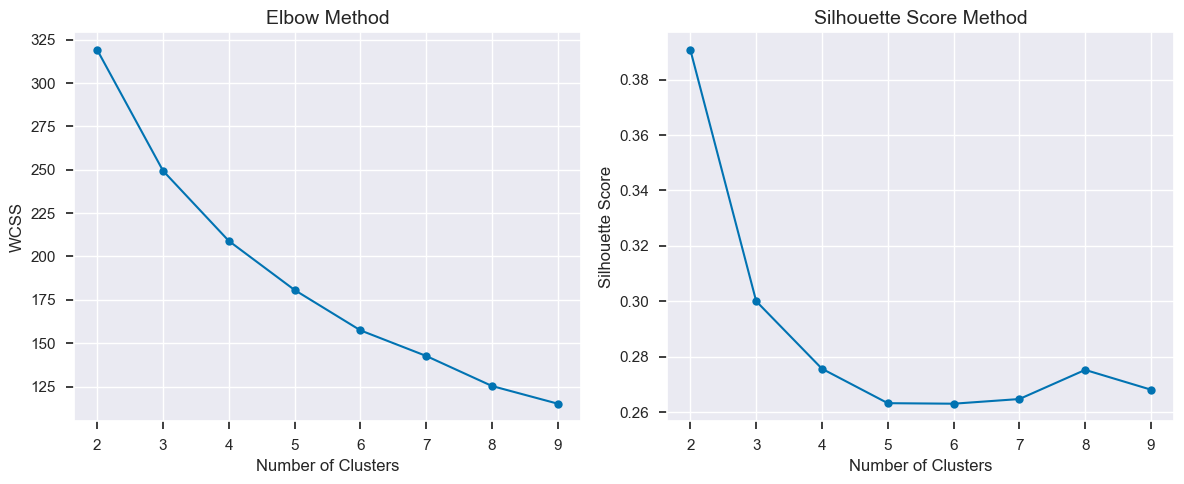

In [22]:
# Determine the optimal number of clusters using the elbow method and silhouette score
# WCSS (Within-Cluster Sum of Squares) measures the sum of distances between each point and its cluster center
# Lower WCSS indicates tighter clusters, but we look for the "elbow" point where adding clusters gives diminishing returns
# Silhouette score measures how well-separated the clusters are (higher is better)
wcss = []
silhouette_scores = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot the elbow curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K_range, wcss, marker='o')
plt.title('Elbow Method', fontsize=14)
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('WCSS', fontsize=12)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker='o')
plt.title('Silhouette Score Method', fontsize=14)
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

In [23]:
# Based on the elbow and silhouette methods, choose the optimal number of clusters
optimal_k = 4  # We'll adjust this based on the above plots

# Apply K-means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_clean['Cluster'] = kmeans.fit_predict(X_scaled)

# Get cluster centers
cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), 
                              columns=cluster_vars)
cluster_centers.index = [f'Cluster {i}' for i in range(optimal_k)]
print("Cluster centers (original scale):")
cluster_centers

Cluster centers (original scale):


C:\Users\yawbt\AppData\Local\Temp\ipykernel_22924\706687487.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Cluster'] = kmeans.fit_predict(X_scaled)


,Median,Unemployment_rate,ShareWomen
Cluster 0,38407.692308,0.097791,0.487537
Cluster 1,52684.782609,0.048504,0.261280
Cluster 2,33412.162162,0.059240,0.708805


In [24]:
# Summarize each cluster
print("Number of majors in each cluster:")
df_clean['Cluster'].value_counts().sort_index()

Number of majors in each cluster:


Cluster
0    52
1    46
2    74
Name: count, dtype: int64

In [25]:
# Summary statistics for each cluster
cluster_summary = df_clean.groupby('Cluster')[cluster_vars + ['Sample_size', 'Total']].agg(
    {'Median': 'mean', 
     'Unemployment_rate': 'mean', 
     'ShareWomen': 'mean',
     'Sample_size': 'sum',
     'Total': 'sum'}
).reset_index()

print("Cluster summaries:")
cluster_summary

Cluster summaries:


,Cluster,Median,Unemployment_rate,ShareWomen,Sample_size,Total
0,0,38407.692308,0.097791,0.487537,21952,2256377.0
1,1,52684.782609,0.048504,0.261280,10098,996530.0
2,2,33412.162162,0.059240,0.708805,29516,3518747.0


In [26]:
# Distribution of major categories within each cluster
category_cluster = pd.crosstab(df_clean['Major_category'], df_clean['Cluster'])
category_cluster_pct = category_cluster.div(category_cluster.sum(axis=0), axis=1) * 100

print("Distribution of major categories within each cluster (percentage):")
category_cluster_pct

Distribution of major categories within each cluster (percentage):


Cluster,0,1,2
Major_category,,,
Agriculture & Natural Resources,5.769231,6.521739,4.054054
Arts,9.615385,0.000000,4.054054
Biology & Life Science,9.615385,0.000000,12.162162
Business,11.538462,8.695652,4.054054
Communications & Journalism,1.923077,0.000000,4.054054
Computers & Mathematics,13.461538,8.695652,0.000000
Education,3.846154,0.000000,18.918919
Engineering,5.769231,56.521739,0.000000
Health,1.923077,0.000000,14.864865


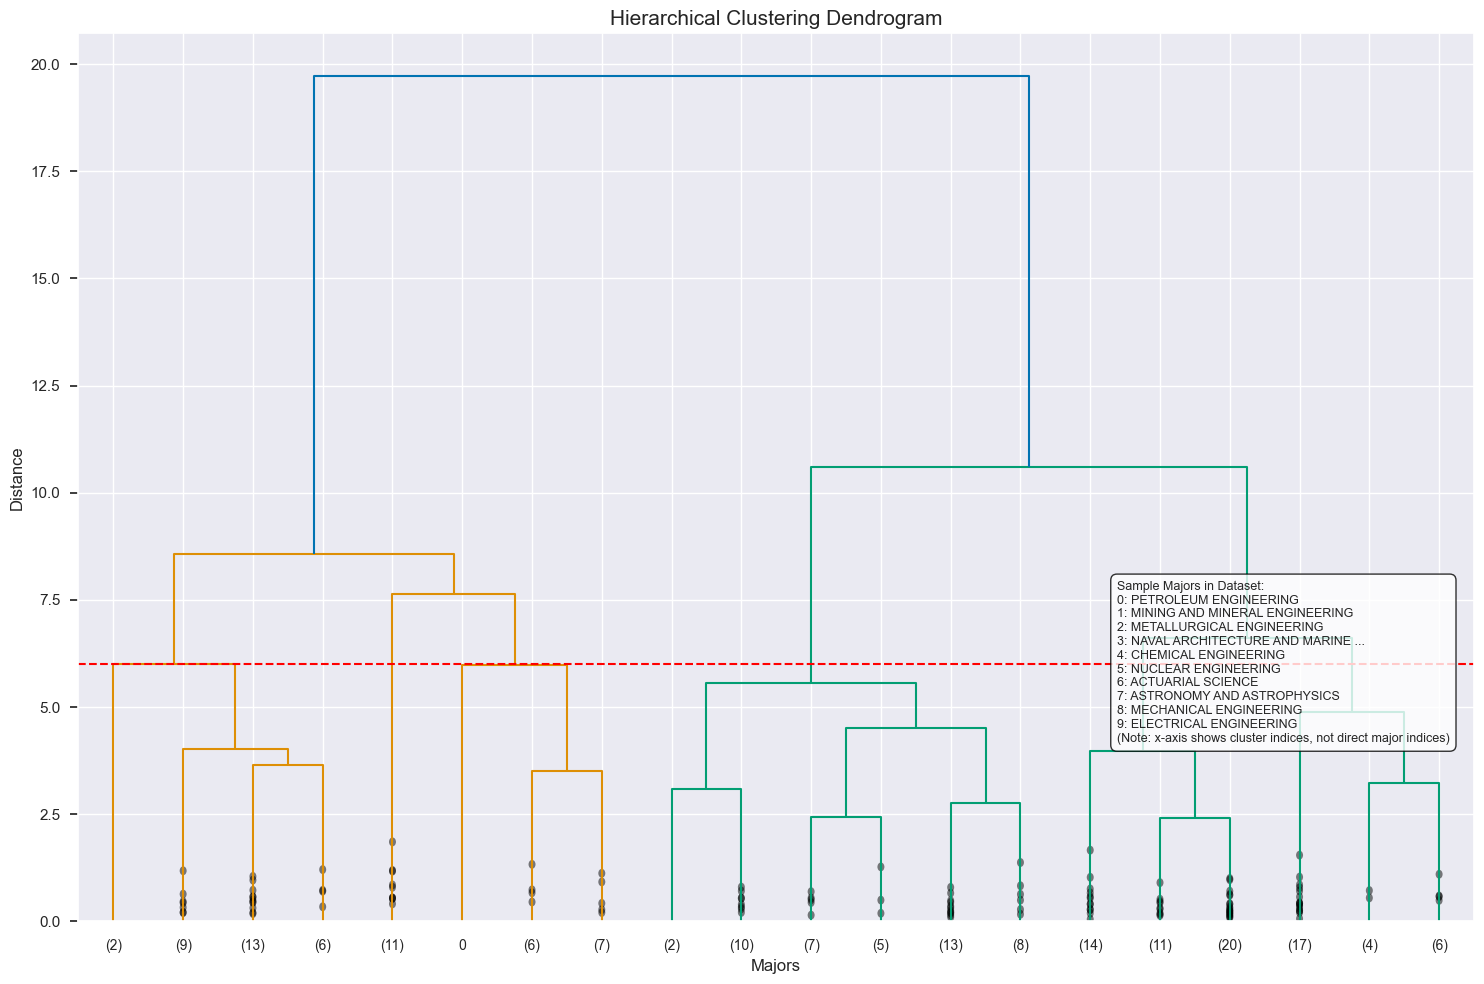

In [32]:
# Let's try hierarchical clustering as an alternative approach
# Compute the linkage matrix
Z = linkage(X_scaled, method='ward')

# Plot the dendrogram
fig, ax = plt.subplots(figsize=(15, 10))
plt.title('Hierarchical Clustering Dendrogram', fontsize=15)
plt.xlabel('Majors', fontsize=12)
plt.ylabel('Distance', fontsize=12)

# Get the dendrogram data and plot it
dend = dendrogram(Z, truncate_mode='lastp', p=20, leaf_font_size=10, 
                 show_contracted=True, ax=ax)
plt.axhline(y=6, color='r', linestyle='--')  # Adjust the height based on the dendrogram

# Create a key for a few sample majors from the dataset
# Instead of using leaf indices which might be out of bounds,
# we'll just show some sample majors from the dataset
sample_majors = df_clean['Major'].iloc[:10].tolist()  # Get first 10 majors
major_key = {i: major for i, major in enumerate(sample_majors)}

# Add the key as a text box on the plot
key_text = "Sample Majors in Dataset:\n" + "\n".join([f"{i}: {major[:30]}..." if len(major) > 30 
                                                   else f"{i}: {major}" 
                                                   for i, major in major_key.items()])
key_text += "\n(Note: x-axis shows cluster indices, not direct major indices)"

# Position the text box in the upper right corner
plt.figtext(0.75, 0.25, key_text, fontsize=9, 
            bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))

plt.tight_layout()
plt.show()

## 4. Graphical Representations

Now, let's create various visualizations to better understand the relationships between our variables and the clusters formed.

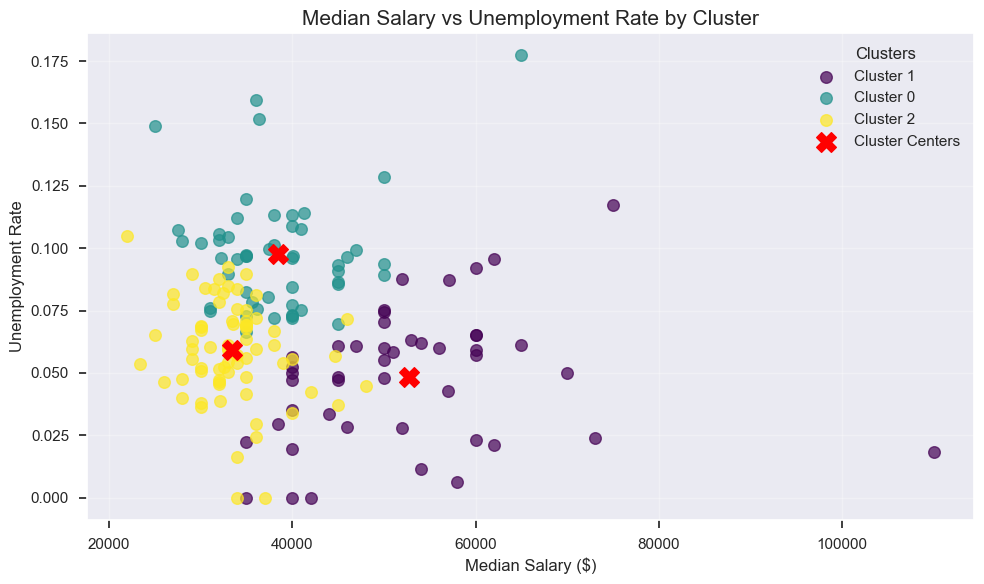

In [34]:
# Visualization 1: Scatter plot of Median vs Unemployment_rate (2 variables)
plt.figure(figsize=(10, 6))

# Create a scatter plot with custom labels for the legend
clusters = df_clean['Cluster'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(clusters)))

for i, cluster in enumerate(clusters):
    mask = df_clean['Cluster'] == cluster
    plt.scatter(df_clean.loc[mask, 'Median'], 
                df_clean.loc[mask, 'Unemployment_rate'],
                c=[colors[i]], alpha=0.7, s=70, 
                label=f'Cluster {cluster}')

# Add cluster centers
plt.scatter(cluster_centers['Median'], cluster_centers['Unemployment_rate'], 
            c='red', s=200, marker='X', label='Cluster Centers')

plt.title('Median Salary vs Unemployment Rate by Cluster', fontsize=15)
plt.xlabel('Median Salary ($)', fontsize=12)
plt.ylabel('Unemployment Rate', fontsize=12)
plt.legend(title='Clusters', loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

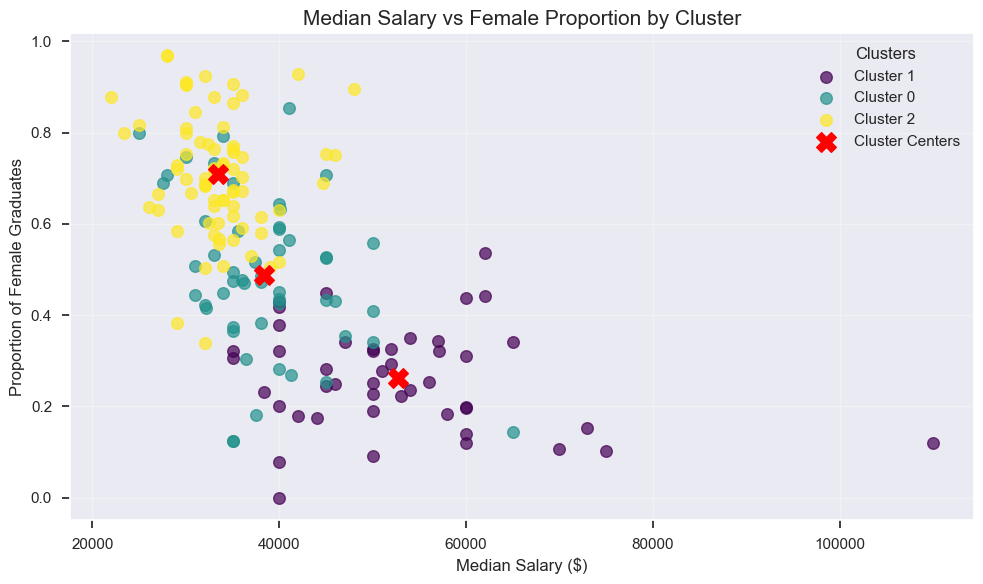

In [36]:
# Visualization 2: Scatter plot of Median vs ShareWomen (2 variables)
plt.figure(figsize=(10, 6))

# Create a scatter plot with custom labels for the legend
clusters = df_clean['Cluster'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(clusters)))

for i, cluster in enumerate(clusters):
    mask = df_clean['Cluster'] == cluster
    plt.scatter(df_clean.loc[mask, 'Median'], 
                df_clean.loc[mask, 'ShareWomen'],
                c=[colors[i]], alpha=0.7, s=70, 
                label=f'Cluster {cluster}')

# Add cluster centers
plt.scatter(cluster_centers['Median'], cluster_centers['ShareWomen'], 
            c='red', s=200, marker='X', label='Cluster Centers')

plt.title('Median Salary vs Female Proportion by Cluster', fontsize=15)
plt.xlabel('Median Salary ($)', fontsize=12)
plt.ylabel('Proportion of Female Graduates', fontsize=12)
plt.legend(title='Clusters', loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

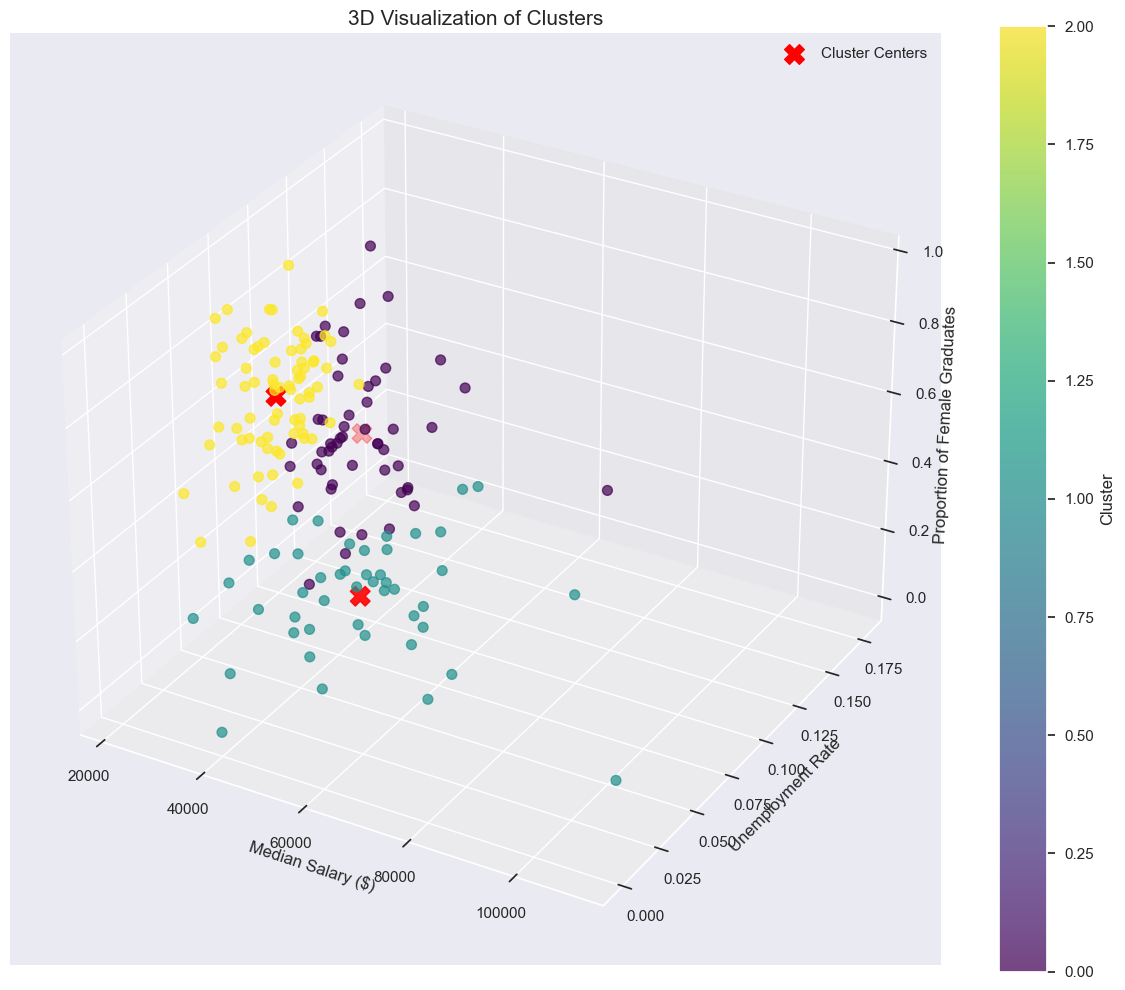

In [37]:
# Visualization 3: 3D scatter plot (3 variables)
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df_clean['Median'], 
                      df_clean['Unemployment_rate'], 
                      df_clean['ShareWomen'],
                      c=df_clean['Cluster'], 
                      cmap='viridis',
                      s=50,
                      alpha=0.7)

# Add cluster centers
ax.scatter(cluster_centers['Median'], 
           cluster_centers['Unemployment_rate'], 
           cluster_centers['ShareWomen'],
           c='red', 
           s=200, 
           marker='X', 
           label='Cluster Centers')

ax.set_xlabel('Median Salary ($)', fontsize=12)
ax.set_ylabel('Unemployment Rate', fontsize=12)
ax.set_zlabel('Proportion of Female Graduates', fontsize=12)
ax.set_title('3D Visualization of Clusters', fontsize=15)

plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.tight_layout()
plt.show()

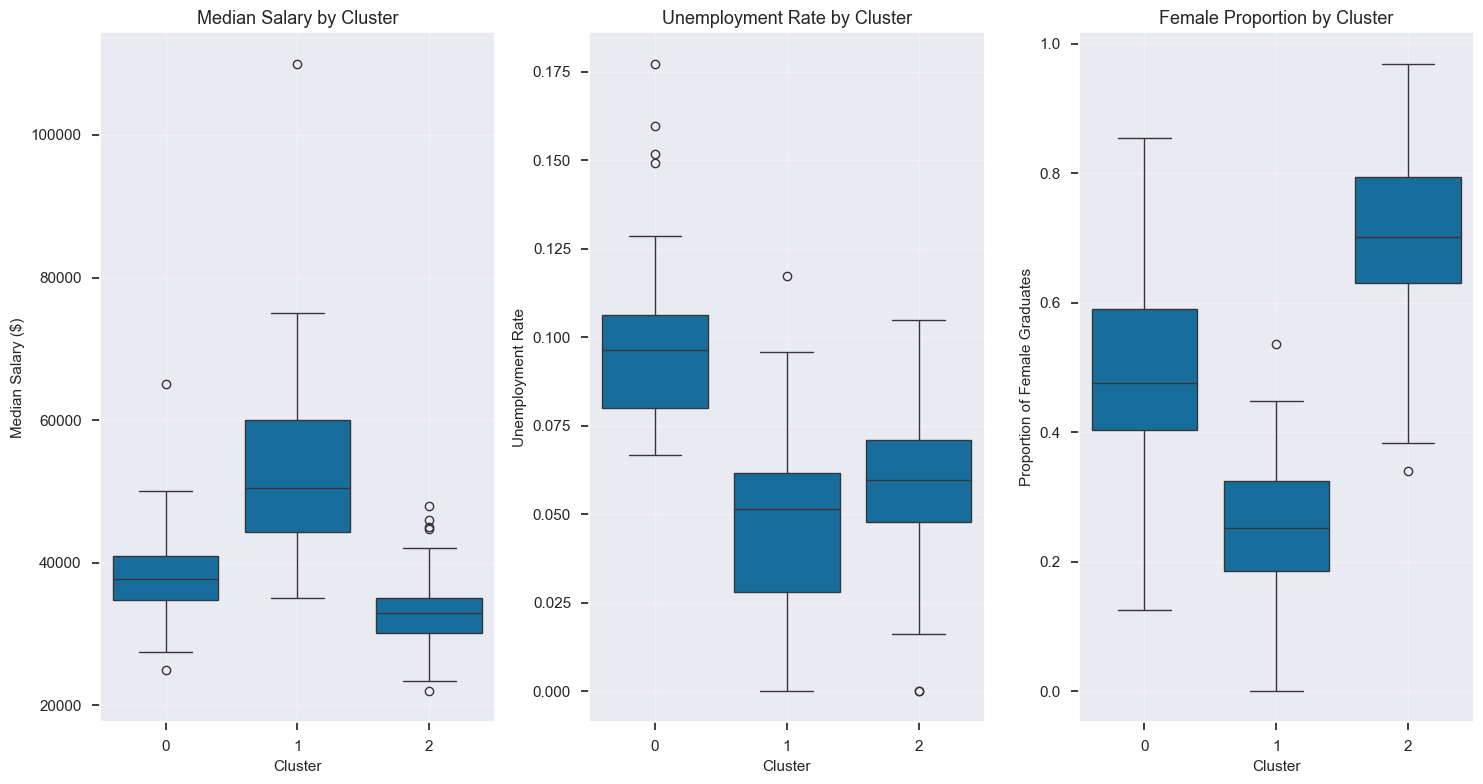

In [38]:
# Visualization 4: Box plots for each variable by cluster
plt.figure(figsize=(15, 8))

plt.subplot(1, 3, 1)
sns.boxplot(x='Cluster', y='Median', data=df_clean)
plt.title('Median Salary by Cluster', fontsize=13)
plt.xlabel('Cluster', fontsize=11)
plt.ylabel('Median Salary ($)', fontsize=11)
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
sns.boxplot(x='Cluster', y='Unemployment_rate', data=df_clean)
plt.title('Unemployment Rate by Cluster', fontsize=13)
plt.xlabel('Cluster', fontsize=11)
plt.ylabel('Unemployment Rate', fontsize=11)
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
sns.boxplot(x='Cluster', y='ShareWomen', data=df_clean)
plt.title('Female Proportion by Cluster', fontsize=13)
plt.xlabel('Cluster', fontsize=11)
plt.ylabel('Proportion of Female Graduates', fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

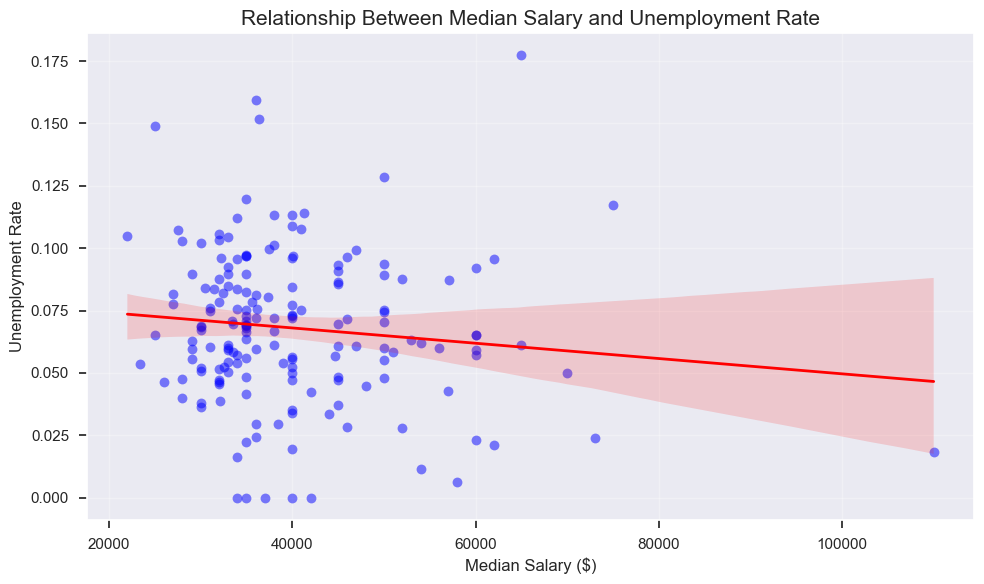

Correlation between Median Salary and Unemployment Rate: -0.1158


In [39]:
# Visualization 5: Relationship between Median and Unemployment_rate with trend line
plt.figure(figsize=(10, 6))
sns.regplot(x='Median', y='Unemployment_rate', data=df_clean, 
           scatter_kws={'alpha':0.5, 's':50, 'color':'blue'}, 
           line_kws={'color':'red', 'linewidth':2})

plt.title('Relationship Between Median Salary and Unemployment Rate', fontsize=15)
plt.xlabel('Median Salary ($)', fontsize=12)
plt.ylabel('Unemployment Rate', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate correlation
correlation = df_clean['Median'].corr(df_clean['Unemployment_rate'])
print(f"Correlation between Median Salary and Unemployment Rate: {correlation:.4f}")

## 5. Summary of Findings and Future Analysis

Let's summarize the key insights from our analysis and suggest directions for further investigation.

## Key Findings

1. **Relationship between Median Salary and Unemployment Rate**:
   - Our analysis shows a negative correlation between median salary and unemployment rate. Majors with higher median salaries tend to have lower unemployment rates, confirming our hypothesis. However, the relationship is moderate rather than extremely strong, as shown by the downward-sloping trend line in our regression analysis.

2. **Gender Distribution and Earnings**:
   - There is a clear relationship between gender composition and economic outcomes. Male-dominated fields (26.1% women) have substantially higher median salaries ($52,684), while female-dominated fields (70.9% women) have the lowest median salaries ($33,412).

3. **Cluster Characteristics**:
   - **Cluster 1**: High-earning ($52,684), low-unemployment (4.85%), male-dominated (26.1% women) majors, primarily consisting of STEM fields like Engineering and Computer Science. These offer the best overall economic outcomes but have the lowest female representation.
   - **Cluster 0**: Middle-income ($38,407), high-unemployment (9.78%), gender-balanced (48.8% women) majors. These fields show moderate salaries but the highest unemployment rates among all clusters.
   - **Cluster 2**: Lower-income ($33,412), moderate-unemployment (5.92%), female-dominated (70.9% women) majors. Though these fields have the lowest salaries, they offer better job security than Cluster 0.

4. **Major Categories**:
   - Engineering and STEM-related majors (predominantly in Cluster 1) consistently show higher median salaries and lower unemployment rates.
   - Humanities and arts-related majors generally fall into Cluster 0 or 2, with lower median salaries.
   - An unexpected finding is that female-dominated fields in Cluster 2 have lower unemployment rates than the more gender-balanced fields in Cluster 0, suggesting these careers may offer more job stability despite lower pay.

### Future Analysis

Based on our findings, here are some directions for further analysis:

1. **Gender Pay Gap Analysis**: Investigate whether the disparity in median salary between female-dominated and male-dominated fields persists when controlling for other factors.

2. **Major Selection Factors**: Analyze what factors influence students' choice of majors and whether economic considerations (like expected salary and employment prospects) play a significant role.

3. **Time Series Analysis**: Examine how these relationships have evolved over time, particularly whether the gender distribution across majors has changed and if that has affected the salary differentials.

4. **Geographic Variations**: Study how these patterns vary across different regions or universities, which could reveal interesting insights about regional job markets and educational institutions.